In [5]:
!pip install -q torch torchvision decord transformers einops timm sentencepiece
!pip install -q 'accelerate>=0.26.0'

In [15]:
import math
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

# Function to show the image at each step
def show_image(image, title="Image"):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Helper function to display images using the custom show_image function
def display_image_step(image, step_name):
    print(f"{step_name}: Image Size - {image.size}")
    show_image(image, step_name)

# Helper function to print tensor details
def display_tensor_step(tensor, step_name):
    print(f"{step_name}: Tensor Shape - {tensor.shape}")
    print(tensor)

# Helper function to print status updates
def display_text_step(text):
    print(text)

# Main processing code

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

print(f'Torch version: {torch.__version__}')

Torch version: 2.5.1+cu124


In [19]:
# Function to create the image transformation pipeline
def build_transform(input_size):
    display_text_step("Building Transformation Pipeline...")
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    return transform

# Function to find closest aspect ratio
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    display_text_step("Initializing Best Ratio...")
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        display_text_step(f"Looping through Target Ratios: {ratio}")
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    display_text_step(f"Selected Closest Ratio: {best_ratio}")
    return best_ratio

# Function for dynamic image preprocessing
def dynamic_preprocess(image, min_num=1, max_num=6, image_size=448, use_thumbnail=False):
    display_text_step("Opening and Converting Image...")
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height
    display_text_step(f"Original Image Size: {orig_width}x{orig_height}, Aspect Ratio: {aspect_ratio}")
    display_image_step(image, "Original Image")

    target_ratios = set((i, j) for n in range(min_num, max_num + 1)
                        for i in range(1, n + 1)
                        for j in range(1, n + 1)
                        if i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    target_aspect_ratio = find_closest_aspect_ratio(aspect_ratio, target_ratios, orig_width, orig_height, image_size)
    target_width, target_height = image_size * target_aspect_ratio[0], image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    display_text_step(f"Resizing to Target Width and Height: {target_width}x{target_height}")
    resized_img = image.resize((target_width, target_height))
    display_image_step(resized_img, "Resized Image")

    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
        display_text_step(f"Resizing and Cropping Block {i + 1}/{blocks}: {split_img.size}")
        display_image_step(split_img, f"Cropped Block {i + 1}")

    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
        display_text_step("Thumbnail Addition")
        display_image_step(thumbnail_img, "Thumbnail Image")

    return processed_images

# Function to load and process the image
def load_image(image_file, input_size=448, max_num=6):
    display_text_step("Loading and Opening Image...")
    image = Image.open(image_file).convert('RGB')
    display_image_step(image, "Loaded Image")

    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    
    pixel_values = []
    for idx, img in enumerate(images):
        transformed_img = transform(img)
        pixel_values.append(transformed_img)
        display_tensor_step(transformed_img, f"Tensor Conversion and Normalization for Image {idx + 1}/{len(images)}")

    # Stack tensors and convert to float16 if required by the model
    pixel_values = torch.stack(pixel_values).to(torch.float16)
    display_tensor_step(pixel_values, "Stacking Tensors (Converted to Float16)")
    
    return pixel_values


In [20]:
# Model loading and question generation code (unchanged)

path = 'OpenGVLab/InternVL2-8B'
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    device_map="auto",
    offload_buffers=True
).eval()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)

generation_config = dict(
    num_beams=1,
    max_new_tokens=1024,
    do_sample=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/accelerate/utils/modeling.py:1390: UserWarning: Current model requires 520097664 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Loading and Opening Image...
Loaded Image: Image Size - (744, 369)


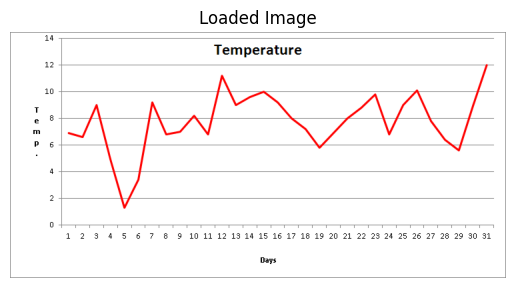

Building Transformation Pipeline...
Opening and Converting Image...
Original Image Size: 744x369, Aspect Ratio: 2.016260162601626
Original Image: Image Size - (744, 369)


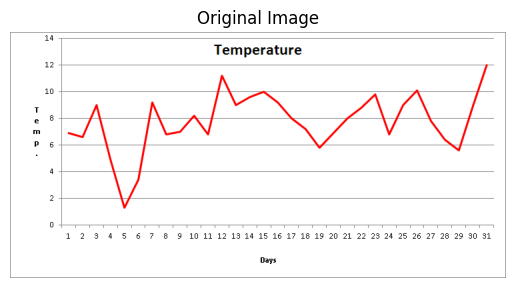

Initializing Best Ratio...
Looping through Target Ratios: (1, 1)
Looping through Target Ratios: (1, 2)
Looping through Target Ratios: (2, 1)
Looping through Target Ratios: (3, 1)
Looping through Target Ratios: (1, 3)
Looping through Target Ratios: (4, 1)
Looping through Target Ratios: (1, 4)
Looping through Target Ratios: (2, 2)
Looping through Target Ratios: (1, 5)
Looping through Target Ratios: (5, 1)
Looping through Target Ratios: (6, 1)
Looping through Target Ratios: (2, 3)
Looping through Target Ratios: (1, 6)
Looping through Target Ratios: (3, 2)
Selected Closest Ratio: (2, 1)
Resizing to Target Width and Height: 896x448
Resized Image: Image Size - (896, 448)


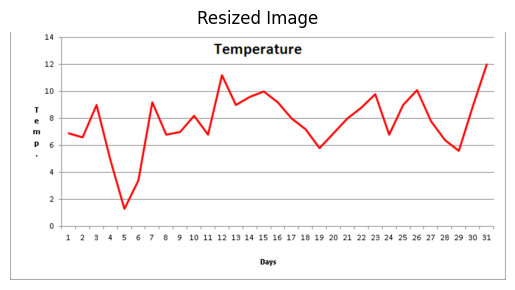

Resizing and Cropping Block 1/2: (448, 448)
Cropped Block 1: Image Size - (448, 448)


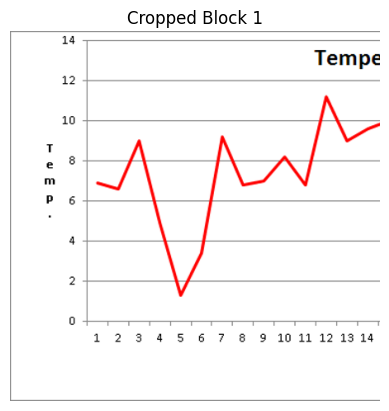

Resizing and Cropping Block 2/2: (448, 448)
Cropped Block 2: Image Size - (448, 448)


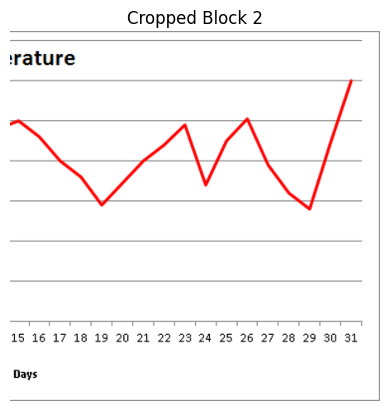

Thumbnail Addition
Thumbnail Image: Image Size - (448, 448)


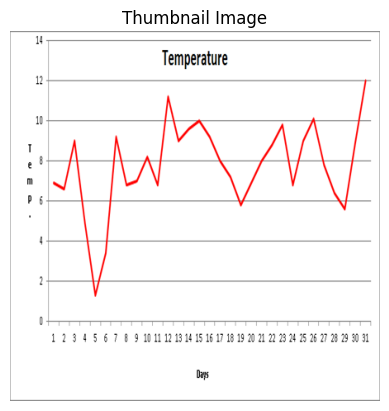

Tensor Conversion and Normalization for Image 1/3: Tensor Shape - torch.Size([3, 448, 448])
tensor([[[0.2282, 0.1597, 0.1426,  ..., 0.1426, 0.1426, 0.1426],
         [0.1768, 1.4098, 1.7694,  ..., 1.7694, 1.7694, 1.7694],
         [0.1597, 1.8722, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [0.1597, 1.8722, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [0.1768, 1.4098, 1.7694,  ..., 1.7694, 1.7694, 1.7694],
         [0.2282, 0.1597, 0.1426,  ..., 0.1426, 0.1426, 0.1426]],

        [[0.3627, 0.2927, 0.2752,  ..., 0.2752, 0.2752, 0.2752],
         [0.3102, 1.5707, 1.9384,  ..., 1.9384, 1.9384, 1.9384],
         [0.2927, 2.0434, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [0.2927, 2.0434, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [0.3102, 1.5707, 1.9384,  ..., 1.9384, 1.9384, 1.9384],
         [0.3627, 0.2927, 0.2752,  ..., 0.2752, 0.2752, 0.2752]],

        [[0.5834, 0.5136, 0.4962,  ..., 0.4962, 0.4962, 0.4962],
         [0.5311, 1.7860, 2.152

In [21]:
# Load and preprocess an example image
pixel_values = load_image('/mnt/code/test_l1.png', max_num=6)
question = 'Analyze this graph'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)

print(f'User: {question}')
print(f'Assistant: {response}')

Loading and Opening Image...
Loaded Image: Image Size - (881, 466)


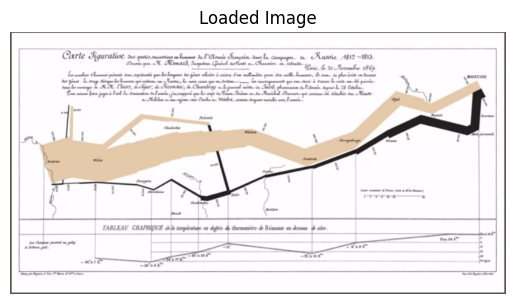

Building Transformation Pipeline...
Opening and Converting Image...
Original Image Size: 881x466, Aspect Ratio: 1.890557939914163
Original Image: Image Size - (881, 466)


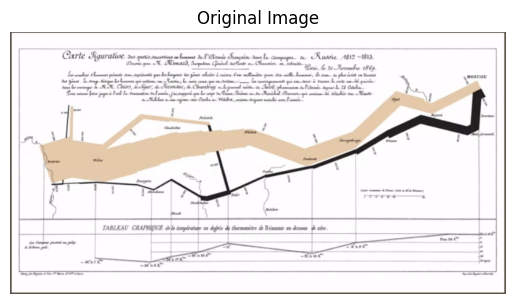

Initializing Best Ratio...
Looping through Target Ratios: (1, 1)
Looping through Target Ratios: (1, 2)
Looping through Target Ratios: (2, 1)
Looping through Target Ratios: (3, 1)
Looping through Target Ratios: (1, 3)
Looping through Target Ratios: (4, 1)
Looping through Target Ratios: (1, 4)
Looping through Target Ratios: (2, 2)
Looping through Target Ratios: (1, 5)
Looping through Target Ratios: (5, 1)
Looping through Target Ratios: (6, 1)
Looping through Target Ratios: (2, 3)
Looping through Target Ratios: (1, 6)
Looping through Target Ratios: (3, 2)
Selected Closest Ratio: (2, 1)
Resizing to Target Width and Height: 896x448
Resized Image: Image Size - (896, 448)


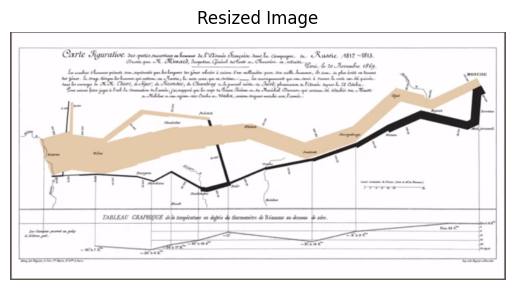

Resizing and Cropping Block 1/2: (448, 448)
Cropped Block 1: Image Size - (448, 448)


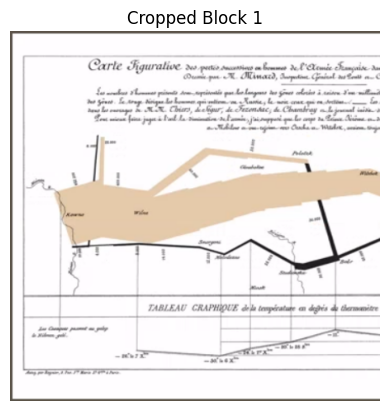

Resizing and Cropping Block 2/2: (448, 448)
Cropped Block 2: Image Size - (448, 448)


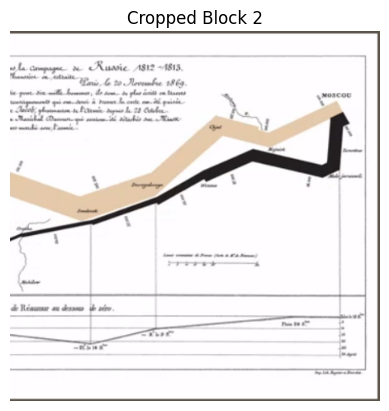

Thumbnail Addition
Thumbnail Image: Image Size - (448, 448)


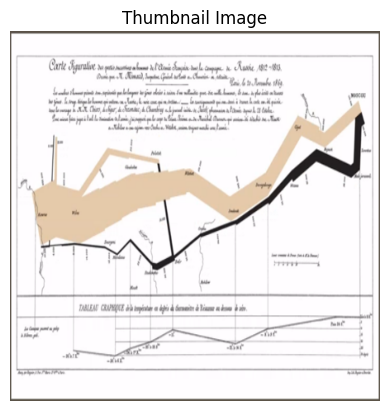

Tensor Conversion and Normalization for Image 1/3: Tensor Shape - torch.Size([3, 448, 448])
tensor([[[-0.5424, -0.5424, -0.5424,  ..., -0.5424, -0.5424, -0.5424],
         [-0.5424, -0.5424, -0.5424,  ..., -0.5767, -0.5767, -0.5767],
         [-0.5424, -0.5424, -0.5253,  ..., -0.3541, -0.3541, -0.3541],
         ...,
         [-0.5938, -0.5938, -0.4739,  ...,  0.7591,  0.7591,  0.7591],
         [-0.5938, -0.5938, -0.5938,  ..., -0.5253, -0.5253, -0.5253],
         [-0.5938, -0.5938, -0.5938,  ..., -0.5596, -0.5596, -0.5596]],

        [[-0.5826, -0.5826, -0.5826,  ..., -0.5826, -0.5826, -0.5826],
         [-0.5826, -0.5826, -0.5826,  ..., -0.6001, -0.6001, -0.6001],
         [-0.5826, -0.5826, -0.5651,  ..., -0.3550, -0.3550, -0.3550],
         ...,
         [-0.5651, -0.5651, -0.4426,  ...,  0.8179,  0.8179,  0.8179],
         [-0.5651, -0.5651, -0.5651,  ..., -0.5301, -0.5301, -0.5301],
         [-0.5651, -0.5651, -0.5651,  ..., -0.5826, -0.5826, -0.5826]],

        [[-0.5321, -0.53

In [22]:
# Load and preprocess an example image
pixel_values = load_image('/mnt/code/Untitled.png', max_num=6)
question = 'Give me a very detailed description of this image in a paragraph format, in at least 500 words.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)

print(f'User: {question}')
print(f'Assistant: {response}')

Loading and Opening Image...
Loaded Image: Image Size - (1135, 1915)


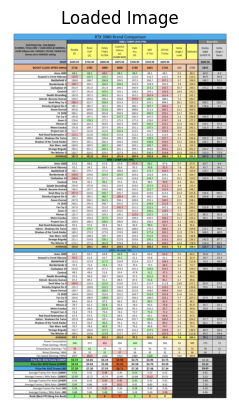

Building Transformation Pipeline...
Opening and Converting Image...
Original Image Size: 1135x1915, Aspect Ratio: 0.5926892950391645
Original Image: Image Size - (1135, 1915)


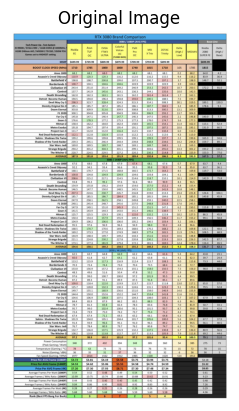

Initializing Best Ratio...
Looping through Target Ratios: (1, 1)
Looping through Target Ratios: (1, 2)
Looping through Target Ratios: (2, 1)
Looping through Target Ratios: (3, 1)
Looping through Target Ratios: (1, 3)
Looping through Target Ratios: (4, 1)
Looping through Target Ratios: (1, 4)
Looping through Target Ratios: (2, 2)
Looping through Target Ratios: (1, 5)
Looping through Target Ratios: (5, 1)
Looping through Target Ratios: (6, 1)
Looping through Target Ratios: (2, 3)
Looping through Target Ratios: (1, 6)
Looping through Target Ratios: (3, 2)
Selected Closest Ratio: (2, 3)
Resizing to Target Width and Height: 896x1344
Resized Image: Image Size - (896, 1344)


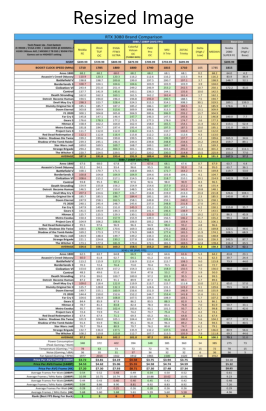

Resizing and Cropping Block 1/6: (448, 448)
Cropped Block 1: Image Size - (448, 448)


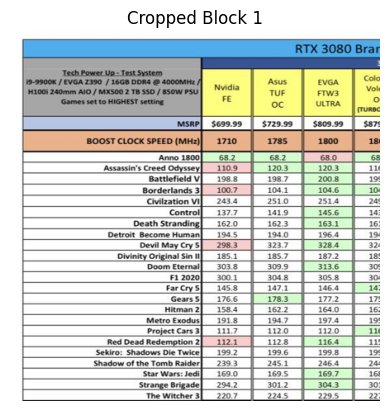

Resizing and Cropping Block 2/6: (448, 448)
Cropped Block 2: Image Size - (448, 448)


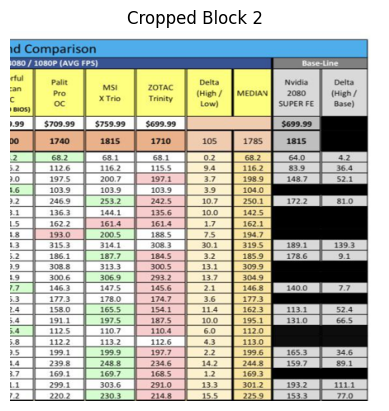

Resizing and Cropping Block 3/6: (448, 448)
Cropped Block 3: Image Size - (448, 448)


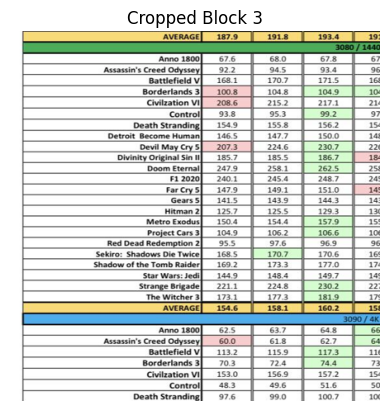

Resizing and Cropping Block 4/6: (448, 448)
Cropped Block 4: Image Size - (448, 448)


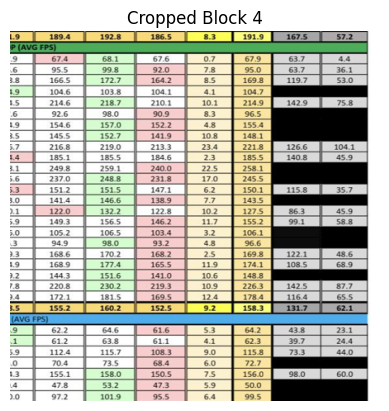

Resizing and Cropping Block 5/6: (448, 448)
Cropped Block 5: Image Size - (448, 448)


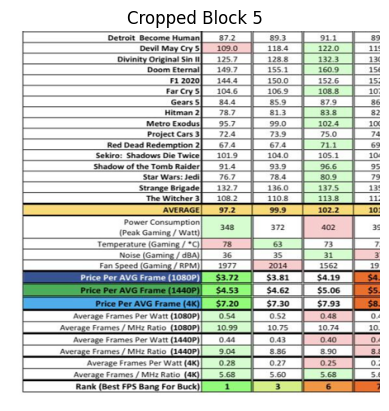

Resizing and Cropping Block 6/6: (448, 448)
Cropped Block 6: Image Size - (448, 448)


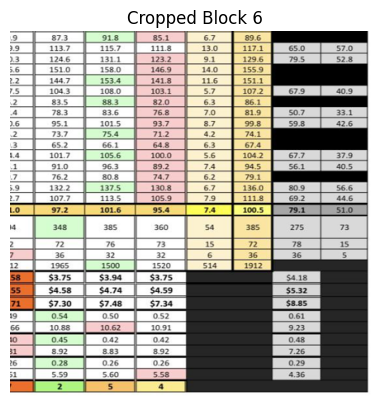

Thumbnail Addition
Thumbnail Image: Image Size - (448, 448)


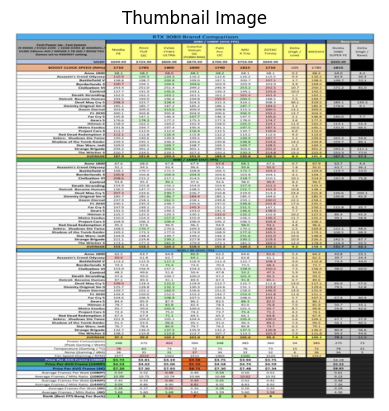

Tensor Conversion and Normalization for Image 1/7: Tensor Shape - torch.Size([3, 448, 448])
tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.1804,  2.1804,  2.1804],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.1975,  2.1975,  2.1975],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2318,  2.2147,  2.2318],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  2.1975,  2.2489,  2.1804],
         [ 2.2489,  2.2489,  2.2489,  ..., -0.0801,  0.0056, -0.0458],
         [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4111,  2.4111,  2.4111],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4111,  2.4286,  2.4111],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ...,  2.3761,  2.4286,  2.3585],
         [ 2.4286,  2.4286,  2.4286,  ...,  0.0476,  0.1352,  0.0826],
         [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357]],

        [[ 2.6400,  2.64

In [23]:
# Load and preprocess an example image
pixel_values = load_image('/mnt/code/ty15s5vg9qz51.jpg', max_num=6)
question = 'Give me a very detailed description of this image in a paragraph format, in at least 500 words.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)

print(f'User: {question}')
print(f'Assistant: {response}')